In [1]:
# IMPORTS
import cvxpy as cp
import numpy as np
import numpy.linalg
import numpy.matlib
from numpy.linalg import norm
import utils.wbpdn.wbpdn_lcurve as lc
import utils.numerical_differentiation.ssplines_R as ssplinesR
from scipy import interpolate
from scipy import signal

from sklearn.preprocessing import PolynomialFeatures

from scipy.linalg import lstsq
from scipy.integrate import odeint

import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

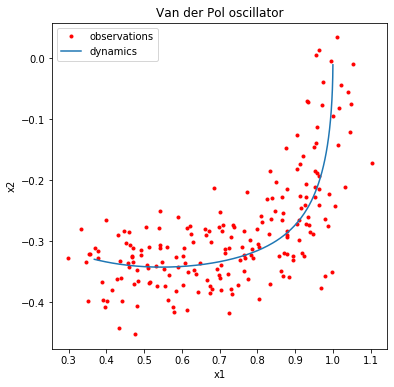

In [3]:
####################### FUNCTIONS #######################

# Simulate dynamical system

def vanderpol(x, t, gamma=1, kappa=1, epsilon=2):
    return [
            x[1],
            -kappa * x[0] - gamma * x[1] - epsilon * x[1] * x[0] ** 2
            ]

gamma=1
kappa=1
epsilon=2

####################### GENERATE DATA #######################

# Simulate dynamics

t0, tf = 0, 2.2  # start and end
dt = 0.01  # time step
n_times = int(np.floor(tf-t0)/dt + 1) #Number of time instances
n_states = 2 #Number of state variables
t_span = np.linspace(t0, tf, n_times)
x0 = [1, 0]
X = odeint(vanderpol, x0, t_span)
x1 = X[:,0]
x2 = X[:,1]

#Compute true derivatives
dX = np.zeros((len(t_span),n_states))
dX[:,0] = x2
dX[:,1] =  -kappa * x1 - gamma * x2 - epsilon * x2 * x1 ** 2

#Corrupt states by adding noise --> Observation model y(t) = x(t) + e(t)
sigma = 0.05
E = sigma * np.random.randn(n_times,n_states)#Additive zero-mean white noise (Assumed Gaussian)

Y = X + E 
t = t_span
m_samples = len(t)#Number of samples

y1 = Y[:,0]
y2 = Y[:,1]

#Plot dynamical system and observations
plt.figure(figsize = (6,6))
plt.plot(y1,y2,'r.')
plt.plot(x1[1:],x2[1:])
plt.title('Van der Pol oscillator')
plt.ylabel('x2')
plt.xlabel('x1')
plt.legend(['observations','dynamics'])
plt.show()

  Convergence criterion reached in 15 iterations.
  Convergence criterion reached in 20 iterations.


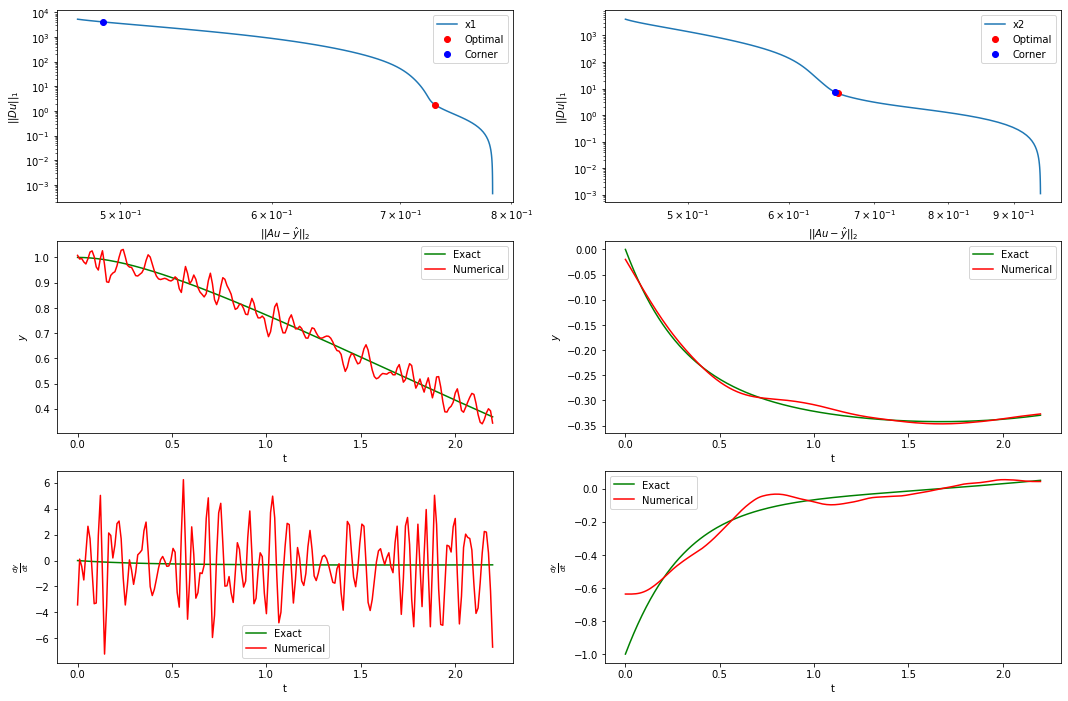

In [4]:
################### DENOISING AND NUMERICAL DIFFERENTIATION - SMOOTHING SPLINES ###################
Y_ss = np.zeros((m_samples, n_states))
DY_ss = np.zeros((m_samples, n_states))

fig_tf, axs_ss = plt.subplots(3, n_states, figsize = (18,12))

#CVX code
for state in range(n_states):
    #Generate full lcurve
    ss_flc = ssplinesR.full_lcurve(Y[:,state], t, lambda_min = 1e-8, lambda_max = 1000, normalize = False, plot_lc = False)
    sol_path = ss_flc[0]
    residual_lc, reg_residual_lc = ss_flc[2]

    sol_error = np.zeros(sol_path.shape[1])
    for i in range(sol_path.shape[1]):
        sol_error[i] = norm(sol_path[:,i] - X[:, state])

    min_indx = np.argmin(sol_error)
    res_min = residual_lc[min_indx]
    reg_min = reg_residual_lc[min_indx]

    #Find corner point
    ss_lc = ssplinesR.lcurve_corner(Y[:,state], t, lambda_min = 1e-8, lambda_max = 1000)
    y_ss = ss_lc[0]
    Y_ss[:,state] = y_ss
    dy_ss = ss_lc[1]
    DY_ss[:,state] = dy_ss
    res_c, reg_c = ss_lc[4]

    axs_ss[0][state].loglog(residual_lc, reg_residual_lc)
    axs_ss[0][state].loglog(res_min, reg_min,'ro')
    axs_ss[0][state].loglog(res_c[-1], reg_c[-1],'bo')
    axs_ss[0][state].set_xlabel(r'$||Au - \hat{y}||_2$')
    axs_ss[0][state].set_ylabel(r'$||Du||_1$')
    axs_ss[0][state].legend([f'x{state+1}','Optimal', 'Corner'])
    
    axs_ss[1][state].plot(t, X[:,state],'g')
    axs_ss[1][state].plot(t, y_ss,'r')
    axs_ss[1][state].set_xlabel('t')
    axs_ss[1][state].set_ylabel(r'$y$')
    axs_ss[1][state].legend(['Exact', 'Numerical'])
    
    axs_ss[2][state].plot(t, dX[:,state],'g')
    axs_ss[2][state].plot(t, dy_ss,'r')
    axs_ss[2][state].set_xlabel('t')
    axs_ss[2][state].set_ylabel(r'$\frac{dy}{dt}$')
    axs_ss[2][state].legend(['Exact', 'Numerical'])
    
#Remove ends
trim = int(np.floor(5 / 100 * m_samples))
Y_ss = Y_ss[trim:-trim,:]
DY_ss = DY_ss[trim:-trim,:]

In [64]:
################### SET UP LINEAR ALGEBRA PROBLEM ###################
#Model to approximate functions f1 = dx1 and f2 = dx2
poly_d = 4
poly = PolynomialFeatures(poly_d)
Phi = poly.fit_transform(Y_ss)
basis_names = poly.get_feature_names()
p_basis = Phi.shape[1]#Number of basis functions

print(basis_names)

#True coefficients
sol_true = np.zeros((p_basis, n_states))

sol_true[2,0] = 1

sol_true[1,1] = - kappa
sol_true[2,1] = - gamma
sol_true[5,1] = - epsilon

['1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2', 'x0^3', 'x0^2 x1', 'x0^2 x2', 'x0 x1^2', 'x0 x1 x2', 'x0 x2^2', 'x1^3', 'x1^2 x2', 'x1 x2^2', 'x2^3']


Solving for state: 1
Solving for state: 2
Solving for state: 3
  Convergence criterion reached in 19 iterations.
Solving for state: 1
  Convergence criterion reached in 18 iterations.
Solving for state: 2
  Convergence criterion reached in 18 iterations.
Solving for state: 3


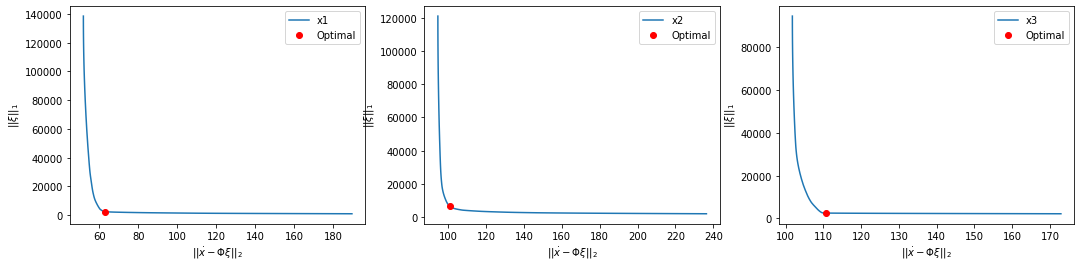

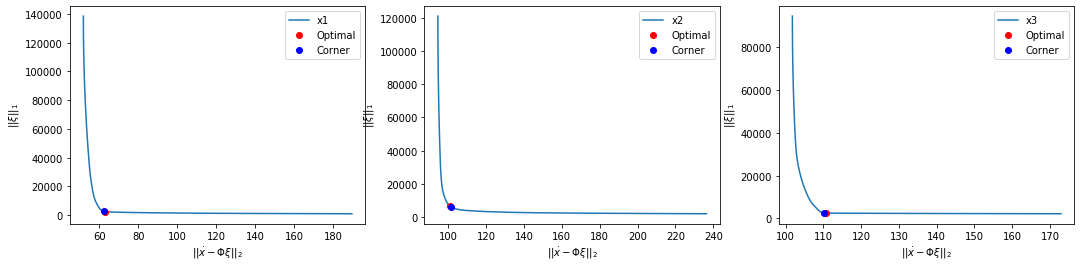

In [66]:
################### FULL L-CURVE: UNWEIGHTED BPDN  ###################

Beta = np.zeros((p_basis, n_states))
residuals = []
reg_residuals = []
res_min_s = []
reg_min_s = []

fig, axs = plt.subplots(1, 3, figsize = (18,4))

for state in range(n_states):
    
    dy = DY_ss[:,state]
    lc_bpdn = lc.full_lcurve(Phi, dy, lambda_min = 1e-5, lambda_max = 100, n_lambdas = 100, tol = 0, normalize = False, plot_lc = False)
    sol_path = lc_bpdn[0]
    residual_lc, reg_residual_lc = lc_bpdn[1]
    residuals.append(residual_lc)
    reg_residuals.append(reg_residual_lc)
    
    sol_error = np.zeros(sol_path.shape[1])
    for i in range(sol_path.shape[1]):
        sol_error[i] = norm(sol_path[:,i] - sol_true[:, state])
        
    min_indx = np.argmin(sol_error)
    res_min_s.append(residual_lc[min_indx])
    reg_min_s.append(reg_residual_lc[min_indx])
    
    axs[state].plot(residual_lc, reg_residual_lc)
    axs[state].plot(residual_lc[min_indx], reg_residual_lc[min_indx],'ro')
    axs[state].set_xlabel(r'$||\dot{x} - \Phi \xi||_2$')
    axs[state].set_ylabel(r'$||\xi||_1$')
    axs[state].legend([f'x{state+1}','Optimal'])
    
    print(f'Solving for state: {state+1}')

    
################### FIND CORNER POINT: UNWEIGHTED BPDN  ###################

Beta = np.zeros((p_basis, n_states))
lc_data = []
fig2, axs2 = plt.subplots(1, 3, figsize = (18,4))

for state in range(n_states):
    
    dy = DY_ss[:,state]
    lc_bpdn = lc.lcurve_corner(Phi, dy, lambda_min = 1e-5, lambda_max = 100, epsilon = 0.001, max_iter = 50, tol = 1e-8, normalize = False, verbose = False)
    
    res_c, reg_c = lc_bpdn[3]
    Beta[:,state] = lc_bpdn[0]
    
    axs2[state].plot(residuals[state], reg_residuals[state])
    axs2[state].plot(res_min_s[state], reg_min_s[state],'ro')
    axs2[state].plot(res_c[-1], reg_c[-1],'bo')
    axs2[state].set_xlabel(r'$||\dot{x} - \Phi \xi||_2$')
    axs2[state].set_ylabel(r'$||\xi||_1$')
    axs2[state].legend([f'x{state+1}','Optimal', 'Corner'])
    
    print(f'Solving for state: {state+1}')

In [67]:
Beta[np.abs(Beta) < 0.1] = 0
Beta

array([[ 2.82858204, -0.9581792 , -1.2236819 ],
       [-5.51679078, 19.62096034,  0.        ],
       [ 7.40090682,  2.93632305,  0.        ],
       [ 0.        ,  0.        , -2.55321415],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.99237121],
       [ 0.        , -0.70171814,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

Solving for state variable x1.
  Weighted iteration 1.
  Convergence criterion reached in 15 iterations.
  Weighted iteration 2.
  Convergence criterion reached in 15 iterations.
  Weighted iteration 3.
  Convergence criterion reached in 15 iterations.


Solving for state variable x2.
  Weighted iteration 1.
  Convergence criterion reached in 16 iterations.
  Weighted iteration 2.
  Convergence criterion reached in 15 iterations.
  Weighted iteration 3.
  Convergence criterion reached in 16 iterations.


Solving for state variable x3.
  Weighted iteration 1.


SolverError: Solver 'CVXOPT' failed. Try another solver, or solve with verbose=True for more information.

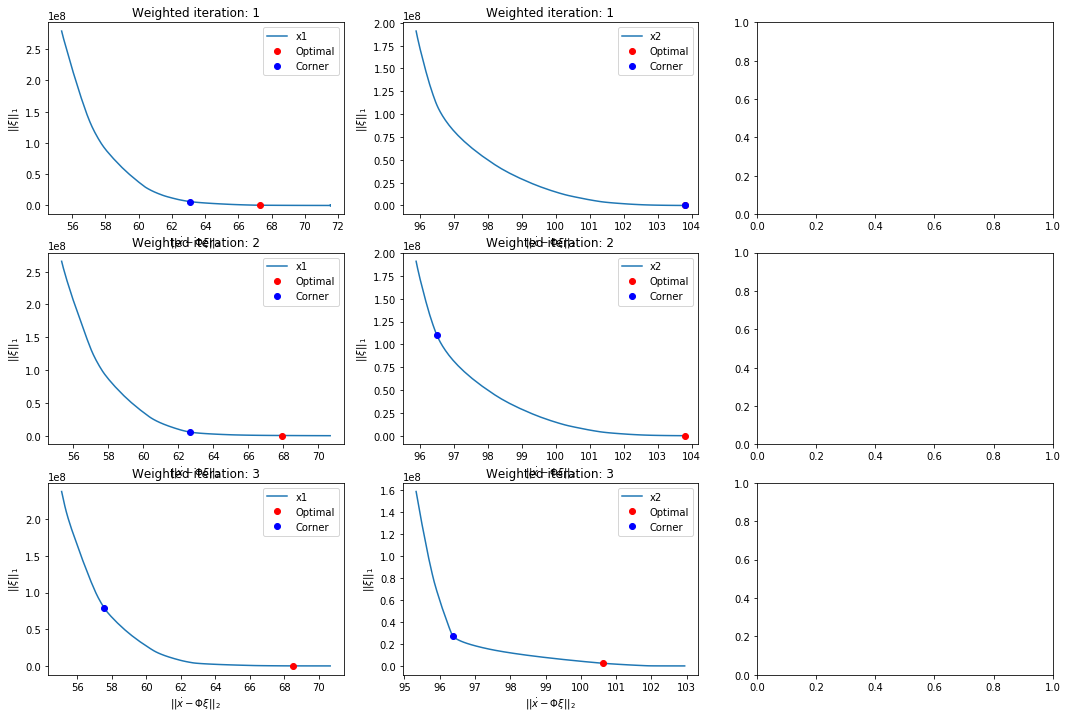

In [71]:
################### WEIGHTED BPDN  ###################
num_itr = 3
q = 2
eps_w = 0.0001
fig_itr, axs_itr = plt.subplots(num_itr, n_states, figsize = (18,12))
Beta_itr = np.zeros((p_basis, n_states, num_itr+1))
Beta_itr[:,:,0] = Beta

for state in range(n_states): 
    
    print(f'Solving for state variable x{state+1}.')
    dy = DY_ss[:,state]
    
    for itr in range(num_itr):
        
        print(f'  Weighted iteration {itr+1}.')

        #Apply weighting
        w = 1 / (np.abs(Beta_itr[:,state, itr]) ** 2 + eps_w)
        
        #Full lcurve
        flc_bpdn = lc.full_lcurve(Phi, dy, w, lambda_min = 1e-6, lambda_max = 0.1, n_lambdas = 100, tol = 0, normalize = False, plot_lc = False)
        sol_path = flc_bpdn[0]
        residual_lc, reg_residual_lc = flc_bpdn[1]
        residuals = residual_lc 
        reg_residuals = reg_residual_lc 

        sol_error = np.zeros(sol_path.shape[1])
        for i in range(sol_path.shape[1]):
            sol_error[i] = norm(sol_path[:,i] - sol_true[:, state])

        min_indx = np.argmin(sol_error)
        res_min_s = residual_lc[min_indx]
        reg_min_s = reg_residual_lc[min_indx]
        
        #Find corner point
        lc_bpdn = lc.lcurve_corner(Phi, dy, w, lambda_min = 1e-6, lambda_max = 0.1, epsilon = 0.001, max_iter = 50, tol = 1e-8, normalize = False, verbose = False)
        res_c, reg_c = lc_bpdn[3]
        Beta_itr[:,state, itr+1] = lc_bpdn[0]
        
        axs_itr[itr][state].plot(residuals, reg_residuals)
        axs_itr[itr][state].plot(res_min_s, reg_min_s,'ro')
        axs_itr[itr][state].plot(res_c[-1], reg_c[-1],'bo')
        axs_itr[itr][state].set_xlabel(r'$||\dot{x} - \Phi \xi||_2$')
        axs_itr[itr][state].set_ylabel(r'$||\xi||_1$')
        axs_itr[itr][state].legend([f'x{state+1}','Optimal', 'Corner'])
        axs_itr[itr][state].set_title(f'Weighted iteration: {itr+1}')        
        
    print('\n')
    


In [16]:
Beta_itr[:,:,-1][np.abs(Beta_itr[:,:,-1]) < 0.1] = 0
Beta_itr[:,:,-1]

array([[ 0.        ,  0.        ,  0.        ],
       [-9.98101125, 27.98546873,  0.        ],
       [ 9.99312357, -0.99096844,  0.        ],
       [ 0.        ,  0.        , -2.66596913],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.99964184],
       [ 0.        , -0.99884027,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])